<a href="https://colab.research.google.com/github/jgrandinetti/AI/blob/master/Chest_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import h5py
import glob
import itertools
from keras import layers
from keras import models, Model
from keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from pathlib import Path
import cv2
from PIL import Image
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16, Xception, DenseNet121
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
!pip install kaggle

In [0]:
# Kaggle API Token
from google.colab import files
files.upload()

In [0]:
# File Config for Kaggle Data
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip
!rm 'chest_xray/train/PNEUMONIA/.DS_Store'
!rm 'chest_xray/train/NORMAL/.DS_Store'
!rm 'chest_xray/test/PNEUMONIA/.DS_Store'
!rm 'chest_xray/test/NORMAL/.DS_Store'
!rm 'chest_xray/val/PNEUMONIA/.DS_Store'
!rm 'chest_xray/val/NORMAL/.DS_Store'

In [0]:
# crop percentage
percent_crop = 0.09


train_p = Path("chest_xray/train/PNEUMONIA/")
train_n = Path("chest_xray/train/NORMAL/")

test_p = Path("chest_xray/test/PNEUMONIA/")
test_n = Path("chest_xray/test/NORMAL/")

val_p = Path("chest_xray/val/PNEUMONIA/")
val_n = Path("chest_xray/val/NORMAL/")

image_list = [train_p, train_n, test_p, test_n, val_p, val_n]
for crop in image_list:
  image = os.listdir(crop)
  for x in image:
    load_path = crop / x
    img = cv2.imread(str(load_path))
    y_crop = img.shape[0]
    x_crop = img.shape[1]
#     Start Crop
    y_crop *= percent_crop
    x_crop *= percent_crop
    y_crop = np.rint(y_crop)
    x_crop = np.rint(x_crop)
    x_crop = x_crop.astype(np.int64)
    y_crop = y_crop.astype(np.int64)
    img = img[(0+y_crop):(img.shape[0]-y_crop), (0+x_crop):(img.shape[1]-x_crop)]

#     # Start Normalized Contrast
#     hist,bins = np.histogram(img.flatten(),256,[0,256])
#     cdf = hist.cumsum()
#     cdf_normalized = cdf * hist.max()/ cdf.max()
#     cdf_m = np.ma.masked_equal(cdf,0)
#     cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
#     cdf = np.ma.filled(cdf_m,0).astype('uint8')
#     img = cdf[img]
    
    # Save Image
    cv2.imwrite(str(load_path),img)

In [4]:
direct = Path("chest_xray")

train_dir = direct / 'train'
valid_dir = direct / 'val'
test_dir = direct / 'test'

img_size = 224 # VGG16
# img_size = 229 # Xception
batch_size = 30

generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)#rescale = 1./255, 
train = generator.flow_from_directory(train_dir, shuffle=True, target_size = (img_size, img_size), class_mode ='categorical', subset='training') #batch_size = batch_size
valid = generator.flow_from_directory(valid_dir, shuffle=False, target_size = (img_size, img_size), class_mode ='categorical')
test = generator.flow_from_directory(test_dir, shuffle=False, target_size = (img_size, img_size), class_mode ='categorical')

train_labels = train.class_indices
valid_labels = valid.class_indices
test_labels = test.class_indices

print("-------------------------")
print("Training Labels")
print(train_labels)
print()
print("Validation Labels")
print(valid_labels)
print()
print("Testing Labels")
print(test_labels)
print("-------------------------")

pn = os.listdir(Path("chest_xray/train/PNEUMONIA/"))
nor = os.listdir(Path("chest_xray/train/NORMAL/"))

print("Pneumonia Images for Training:",len(pn))
print("Normal Images for Training:", len(nor))

cwr = len(pn) / len(nor)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
-------------------------
Training Labels
{'NORMAL': 0, 'PNEUMONIA': 1}

Validation Labels
{'NORMAL': 0, 'PNEUMONIA': 1}

Testing Labels
{'NORMAL': 0, 'PNEUMONIA': 1}
-------------------------
Pneumonia Images for Training: 3875
Normal Images for Training: 1341


In [0]:
# vgg16 = VGG16(include_top=True)
# vgg16.trainable = True

# # x = layers.Conv2D(1028, (1,1), activation='relu')(vgg16.layers[-5].output)
# x = layers.Flatten()(vgg16.layers[-5].output)
# x = (layers.Dense(64, activation='relu'))(x) #64
# x = (layers.Dropout(0.5))(x)
# x = (layers.Dense(2, activation='sigmoid'))(x) #softmax
# model = Model(input=vgg16.input, output=x)

# optimizer = Adam(lr=0.00001)
# class_weight = {0:cwr, 1:1}
# estop = EarlyStopping(patience=5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

In [0]:
# # Xception Pre-Trained Model

# xcep = Xception(include_top=True)
# xcep.trainable = True

# x = (layers.Dense(2, activation='sigmoid'))((xcep.output))
# model = Model(input=xcep.input, output=x)

# optimizer = Adam(lr=0.0001)
# class_weight = {0:cwr, 1:1}
# estop = EarlyStopping(patience=5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

In [5]:
# DenseNet121

K.set_image_dim_ordering('tf')

dnet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
dnet.trainable=True

x = Flatten()(dnet.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
model = Model(input=dnet.input, output=x)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.1,)
class_weight = {0:cwr, 1:1}
estop = EarlyStopping(patience=4)
# checkpoint
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [6]:
model_hist = model.fit_generator(train, steps_per_epoch = 326, epochs = 12, validation_data=test, validation_steps = 10, class_weight = class_weight)# callbacks=[]

Epoch 1/12
326/326 [==============================] - 344s 1s/step - loss: 0.5425 - acc: 0.7710 - val_loss: 1.1267 - val_acc: 0.8844
Epoch 2/12
326/326 [==============================] - 305s 936ms/step - loss: 0.2750 - acc: 0.9113 - val_loss: 0.1779 - val_acc: 0.9342
Epoch 3/12
326/326 [==============================] - 309s 947ms/step - loss: 0.2483 - acc: 0.9387 - val_loss: 1.2153 - val_acc: 0.8781
Epoch 4/12
326/326 [==============================] - 304s 932ms/step - loss: 0.1774 - acc: 0.9444 - val_loss: 0.5193 - val_acc: 0.9375
Epoch 5/12
326/326 [==============================] - 307s 943ms/step - loss: 0.1838 - acc: 0.9554 - val_loss: 1.0210 - val_acc: 0.8969
Epoch 6/12
326/326 [==============================] - 306s 938ms/step - loss: 0.1709 - acc: 0.9554 - val_loss: 2.0436 - val_acc: 0.7993
Epoch 7/12
326/326 [==============================] - 305s 935ms/step - loss: 0.1401 - acc: 0.9609 - val_loss: 0.5695 - val_acc: 0.9375
Epoch 8/12
326/326 [==============================]

Accuracy: 86.38%
Loss: 1.34
------------------------


Confusion Matrix
Classifications
             precision    recall  f1-score   support

     Normal       0.97      0.65      0.78       234
  Penumonia       0.82      0.99      0.90       390

avg / total       0.88      0.86      0.85       624



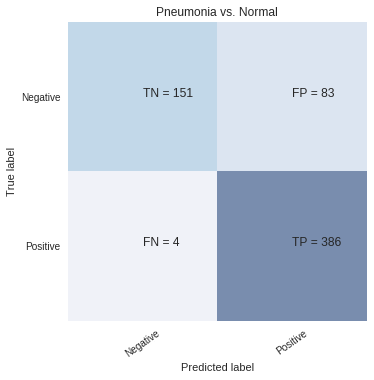

In [7]:
acc = model.evaluate_generator(test, steps=(len(test)))
x = acc[1]*100
y = acc[0]
print("Accuracy: %.2f%%" % x)
print("Loss: %.2f" % y)
print("------------------------")
print()
print()


test.reset()
Y_pred = model.predict_generator(test, 592 // batch_size+1) #656, 624
classes = test.classes[test.index_array]
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
conf = (confusion_matrix(test.classes[test.index_array],y_pred))
#print(confusion_matrix(test.classes, y_pred))
print('Classifications')
target_names = ['Normal', 'Penumonia']
print(classification_report(test.classes[test.index_array], y_pred, target_names=target_names))


plt.clf()
plt.imshow(conf, interpolation='nearest', alpha=0.5, cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
plt.title('Pneumonia vs. Normal')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=35)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(conf[i][j]))
plt.grid(False)
plt.show()

Actual: Pneumonia
Prediction: Pneumonia
Photo # 1


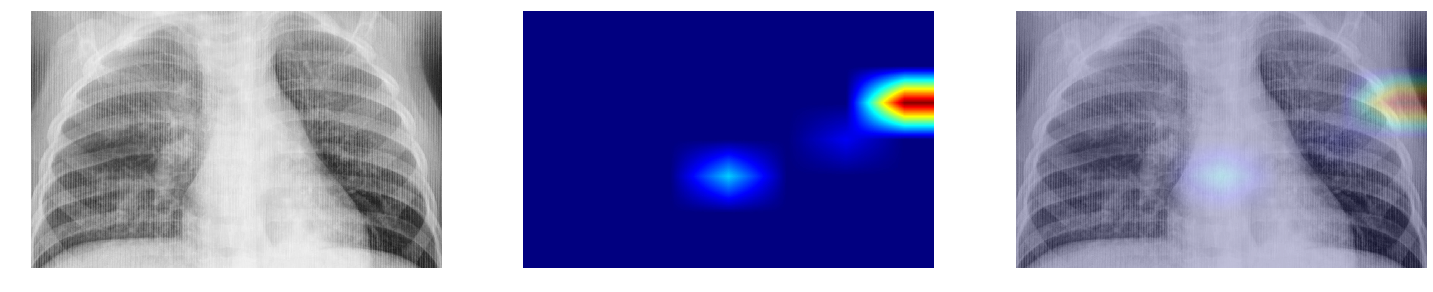

Actual: Normal
Prediction: Normal
Photo # 2


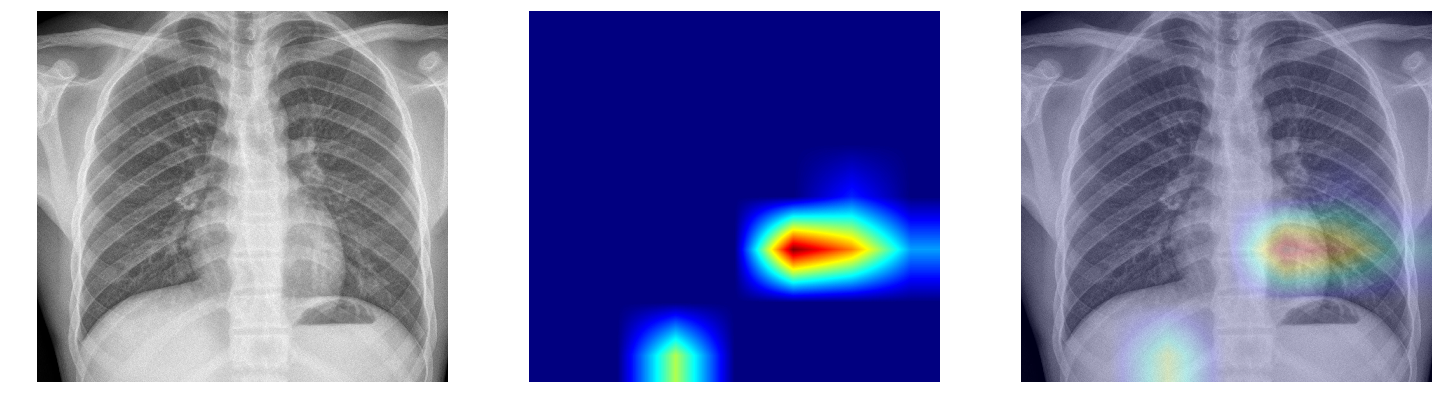

Actual: Normal
Prediction: Pneumonia
Photo # 3


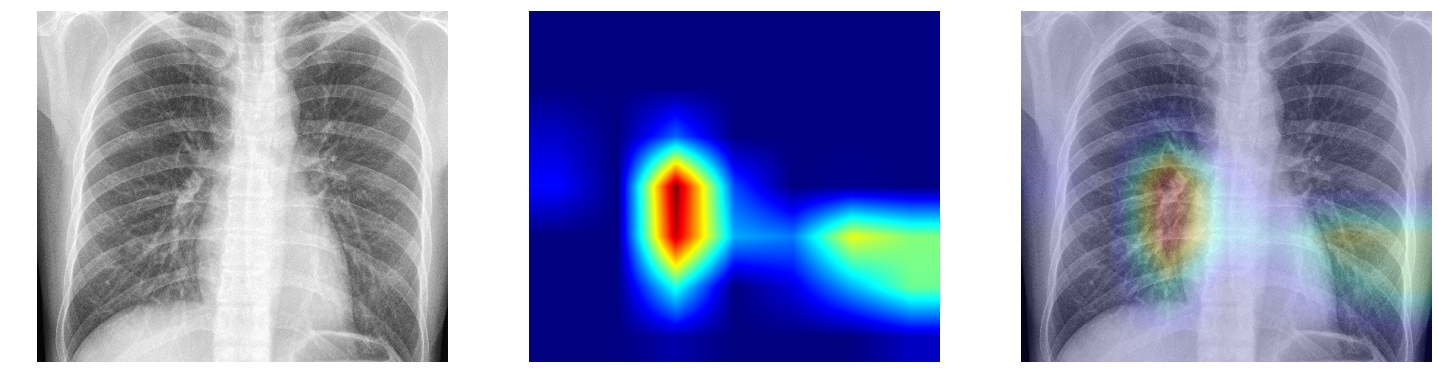

Actual: Normal
Prediction: Pneumonia
Photo # 4


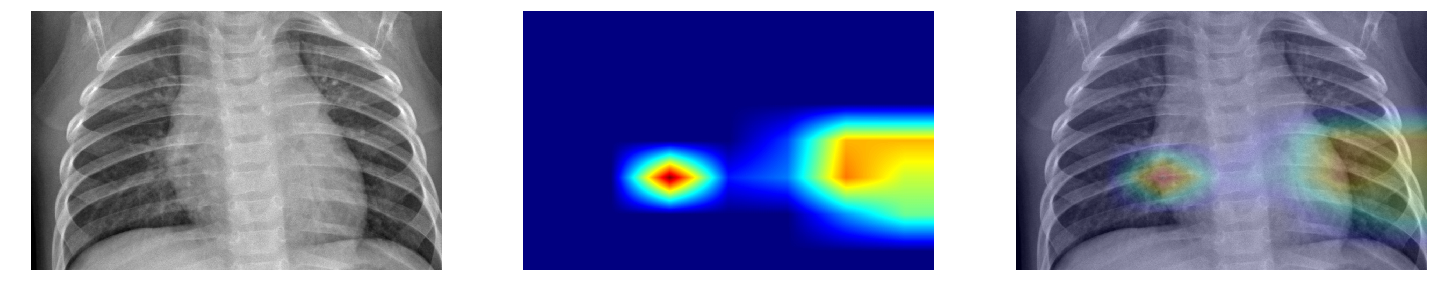

Actual: Normal
Prediction: Pneumonia
Photo # 5


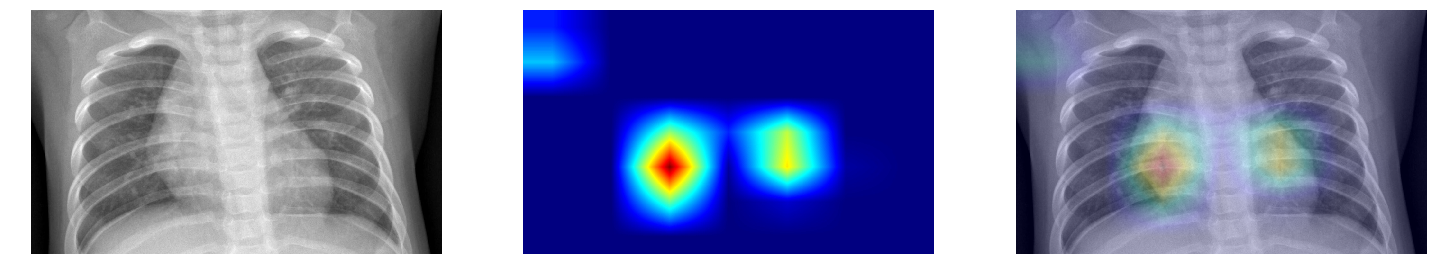

Actual: Normal
Prediction: Pneumonia
Photo # 6


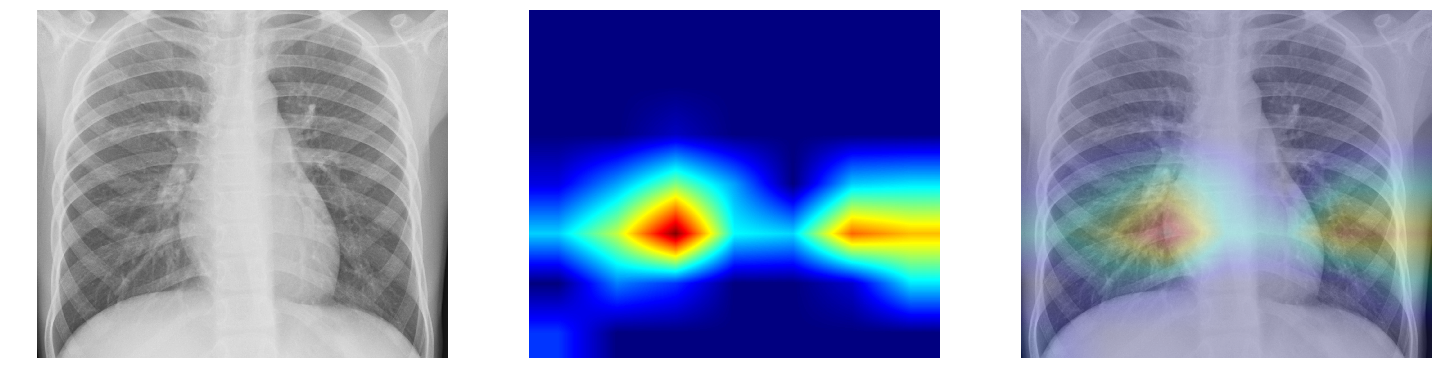

Actual: Normal
Prediction: Normal
Photo # 7


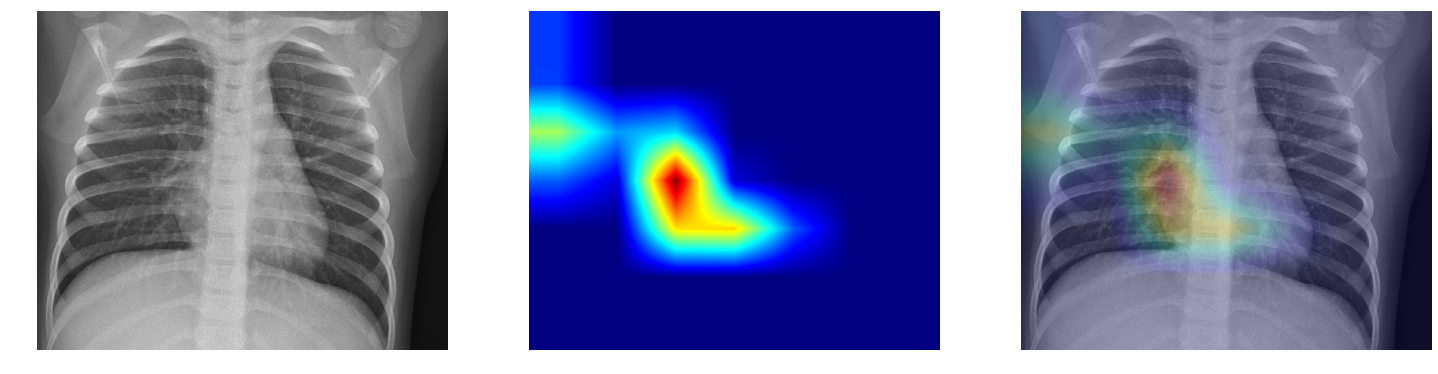

Actual: Pneumonia
Prediction: Pneumonia
Photo # 8


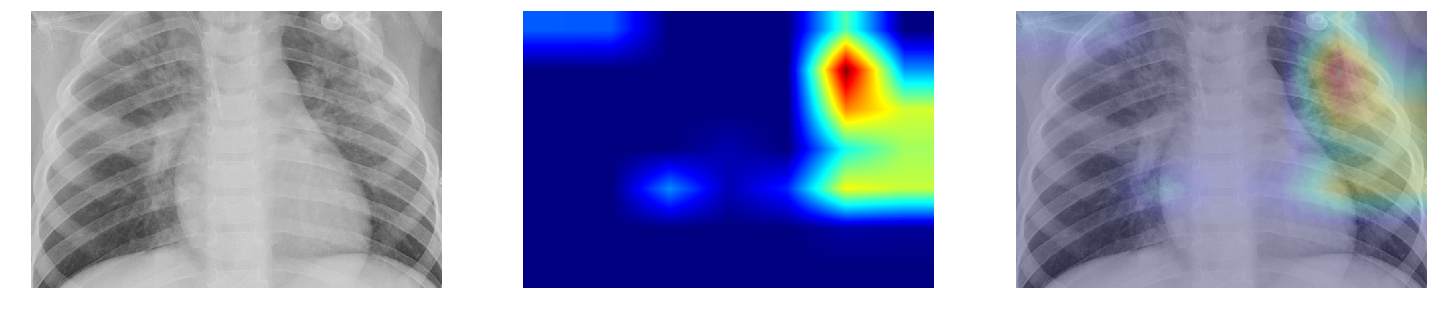

Actual: Pneumonia
Prediction: Pneumonia
Photo # 9


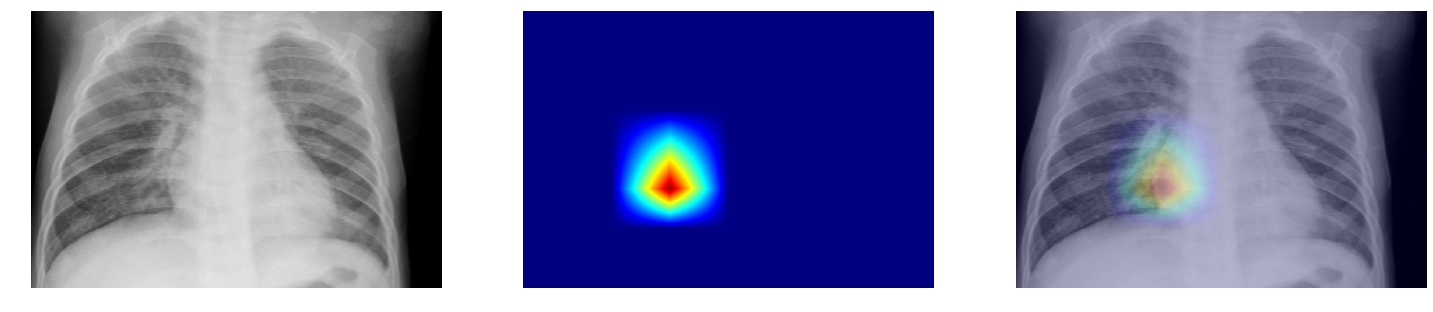

Actual: Normal
Prediction: Normal
Photo # 10


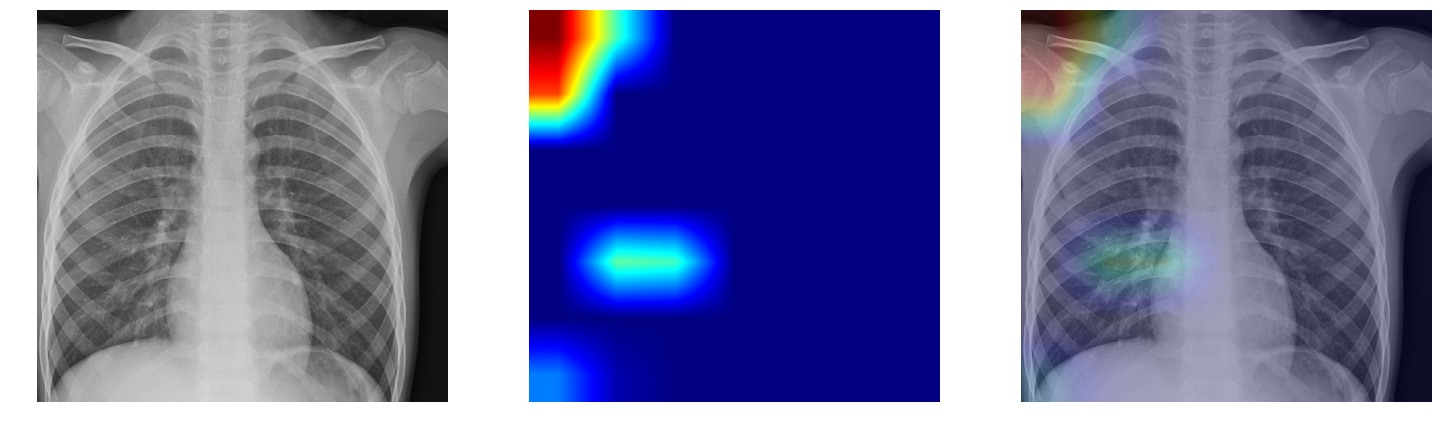

In [26]:
np.random.seed(22)
cc = 1

# conv = 'conv2d_3' # Xception
# conv = 'block3_conv3' # VGG16
conv = 'conv5_block16_2_conv' # DenseNet121
conv_size = 31 # Conv Size
conv_up_size = 400
num_images_print = 10
num_layers = 1 # Number of convolutions to superimpose.

for xx in range(num_images_print):

  det_flow_type = np.random.randint(2)

  if det_flow_type == 0:
    flow_image = Path("chest_xray/test/NORMAL/")
    flow_type = "Normal"
  if det_flow_type == 1:
    flow_image = Path("chest_xray/test/PNEUMONIA/")
    flow_type = "Pneumonia"

  image = os.listdir(flow_image)

  image_num = np.random.randint(200)

  load_path = flow_image / image[image_num]

  img = load_img(load_path, target_size=(img_size, img_size))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  x = preprocess_input(img_tensor)
  preds = model.predict(x)
  t = np.argmax(preds[0])
  img = cv2.imread(str(load_path))

  if t == 0:
    predic = "Normal"
  if t == 1:
    predic = "Pneumonia"  

  print("Actual:", flow_type)
  print("Prediction:", predic)
  print("Photo #", cc)
  cc += 1
  
  for zz in range(num_layers):
    llayer = model.output[:,t]
    last_conv_layer = model.get_layer(conv)
    grads = K.gradients(llayer, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(conv_size):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap) #255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    cv2.imwrite('colormap.jpg', heatmap)
    colormap = cv2.imread('colormap.jpg')

    if zz == 0:
      heatmap1 = heatmap
#       conv = 'conv2d_4' 
#       conv = 'block4_conv3'
      conv = 'conv5_block16_2_conv'
#       conv_size = conv_up_size
    elif zz == 1:
      heatmap2 = heatmap
#       conv = 'conv2d_5' 
#       conv = 'block5_conv3'
      conv = 'conv5_block16_2_conv'
    elif zz == 2:
      heatmap3 = heatmap
      
  
  total_heatmap = heatmap1
#   total_heatmap = heatmap1 + heatmap2
#   total_heatmap = heatmap1 + heatmap2 + heatmap3
  
  
  
      

  fig = plt.figure(xx, figsize=(25, 25))
  ax1 = fig.add_subplot(1,3,1)
  ax1 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax1 = plt.grid(None)
  ax1 = plt.axis('off')

  ax2 = fig.add_subplot(1,3,2)
#   ax2 = plt.imshow(total_heatmap)
  ax2 = plt.imshow(cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB))
  ax2 = plt.grid(None)
  ax2 = plt.axis('off')

  ax3 = fig.add_subplot(1,3,3)
#   ax3 = plt.imshow(total_heatmap)
  ax3 = plt.imshow(cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB))
  ax3 = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), alpha=0.8)
  ax3 = plt.grid(None)
  ax3 = plt.axis('off')

  plt.show()
